## VSSL (1) vs NSL (0)

### Import Libraries

In [39]:
from util_comp import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import time
import warnings

import xgboost


from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression

# Makes sure we see all columns
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
df = pd.DataFrame(main(one_hot=True))
print(df.shape)
df.head()

Elapsed time to compute age categorisation: 0 minutes and 0 seconds
Elapsed time to compute correct systematic error: 0 minutes and 11 seconds
Elapsed time to compute load column names: 0 minutes and 0 seconds
Elapsed time to compute MICE imputation: 1 minutes and 6 seconds
Elapsed time to compute complete MICE imputation: 1 minutes and 6 seconds
Elapsed time to compute categorisation of outcome column: 0 minutes and 4 seconds
Elapsed time to compute change values in catagorical columns: 1 minutes and 56 seconds
Elapsed time to compute OneHotEncoding: 0 minutes and 1 seconds
Elapsed time to compute Full process: 3 minutes and 17 seconds
(44535, 427)


Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?  \
0                                                0.0                                                                   
1                                                0.0                                                                   
2                                                2.0                                                                   
3                                                0.0                                                                   
4                                                0.0                                                                   

   Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?  \
0                                                0.0                                                                    
1                                                0.0                                                                    
2                                                0.0                                                                    
3                                                0.0                                                                    
4                                                0.0                                                                    

   Q4- (13 to 17 years old) In each of the following age groups, how many children live totally or partially with you?  \
0                                                0.0                                                                     
1                                                0.0                                                                     
2                                                0.0                                                                     
3                                                0.0                                                                     
4                                                2.0                                                                     

   Q4- (18 years and over) In each of the following age groups, how many children live totally or partially with you?  \
0                                                0.0                                                                    
1                                                0.0                                                                    
2                                                0.0                                                                    
3                                                0.0                                                                    
4                                                2.0                                                                    

   outcome  (Q1- Your sex?_A man,)  (Q1- Your sex?_A woman,)  \
0        2                       0                         1   
1        2                       0                         1   
2        0                       0                         1   
3        0                       0                         1   
4        0                       0                         1   

   (Q1- Your sex?_None,)  (Q2- How old are you?_18 - 30,)  \
0                      0                                0   
1                      0                                0   
2                      0                                0   
3                      0                                0   
4                      0                                1   

   (Q2- How old are you?_30 - 39,)  (Q2- How old are you?_40 - 44,)  \
0                                0                                1   
1                                0                                0   
2                                0                                1   
3                                0                         

In [3]:
df.describe()

Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?  \
count                                       44535.000000                                                                   
mean                                            0.234288                                                                   
std                                             0.509298                                                                   
min                                             0.000000                                                                   
25%                                             0.000000                                                                   
50%                                             0.000000                                                                   
75%                                             0.000000                                                                   
max                                             9.000000                                                                   

       Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?  \
count                                       44535.000000                                                                    
mean                                            0.299405                                                                    
std                                             0.603759                                                                    
min                                             0.000000                                                                    
25%                                             0.000000                                                                    
50%                                             0.000000                                                                    
75%                                             0.000000                                                                    
max                                             9.000000                                                                    

       Q4- (13 to 17 years old) In each of the following age groups, how many children live totally or partially with you?  \
count                                       44535.000000                                                                     
mean                                            0.245290                                                                     
std                                             0.533775                                                                     
min                                             0.000000                                                                     
25%                                             0.000000                                                                     
50%                                             0.000000                                                                     
75%                                             0.000000                                                                     
max                                             9.000000                                                                     

       Q4- (18 years and over) In each of the following age groups, how many children live totally or partially with you?  \
count                                       44535.000000                                                                    
mean                                            0.257416                                                                    
std                                             0.599190                                                                    
min                                             0.000000                                                                    
25% 

#### split data to train and test sets

In [4]:
data = df

# Split the data for training and evaluation
# X: features with the outcome column removed, where outcome is 0 or 1
# y: outcome column

# get the rows withs outcome 0 or 1
X = data[(data['outcome'] == 0) | (data['outcome'] == 1)].drop('outcome', axis=1, inplace=False)
X.columns = [str(i) for i in X.columns]
y = data[(data['outcome'] == 0) | (data['outcome'] == 1)]['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


#### Train the Random Forest model

In [5]:
# Fit RF (blackbox) model
t1 = time.time()
sl = RandomForestClassifier(class_weight='balanced')
sl.fit(X_train, y_train)
t2 = time.time()
print(time_e(t1, t2, "fitting RF model"))

Elapsed time to compute fitting RF model: 0 minutes and 5 seconds


In [6]:
y_pred = sl.predict(X_test)
y_pred_proba = sl.predict_proba(X_test)

In [7]:
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy of test: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy of train: {accuracy_score(y_train, sl.predict(X_train))}")

# ROAUC

print(f"ROAUC: {roc_auc_score(y_test, y_pred_proba[:,1])}")
print(f"Confusin matrix: \n{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

F1 Score: 0.4641429253790244
Accuracy of test: 0.852852421324903
Accuracy of train: 1.0
ROAUC: 0.6968092696358316
Confusin matrix: 
[[5931    0]
 [1024    4]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      5931
           1       1.00      0.00      0.01      1028

    accuracy                           0.85      6959
   macro avg       0.93      0.50      0.46      6959
weighted avg       0.87      0.85      0.79      6959



## Explanantion using SHAP

In [8]:
explainer = shap.TreeExplainer(sl)

# Calculate shapley values for test data
start_index = 0
end_index = 10

# time to run 10 samples
s_time = time.time()
shap_values = explainer.shap_values(X_test[start_index:end_index]) # 0 - 9
e_time = time.time()
time_e(s_time, e_time, f"Shapley values for test data[{start_index}:{end_index}]")
X_test[start_index:end_index]

Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?  \
37283                                                0.0                                                                   
26982                                                0.0                                                                   
38636                                                1.0                                                                   
12905                                                0.0                                                                   
15547                                                0.0                                                                   
2067                                                 0.0                                                                   
31922                                                0.0                                                                   
39880                                                0.0                                                                   
1763                                                 0.0                                                                   
30383                                                0.0                                                                   

       Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?  \
37283                                                0.0                                                                    
26982                                                0.0                                                                    
38636                                                0.0                                                                    
12905                                                1.0                                                                    
15547                                                0.0                                                                    
2067                                                 0.0                                                                    
31922                                                0.0                                                                    
39880                                                0.0                                                                    
1763                                                 0.0                                                                    
30383                                                0.0                                                                    

       Q4- (13 to 17 years old) In each of the following age groups, how many children live totally or partially with you?  \
37283                                                0.0                                                                     
26982                                                0.0                                                                     
38636                                                0.0                                                                     
12905                                                1.0                                                                     
15547                                                0.0                                                                     
2067                                                 0.0                                                                     
31922                                                0.0                                                                     
39880                                                1.0                                                                     
1763                                                 0.0                                                                     
30383 

In [9]:
y_test[start_index:end_index]

37283    0
26982    0
38636    0
12905    1
15547    0
2067     0
31922    0
39880    0
1763     0
30383    0
Name: outcome, dtype: int64

### SHAP Values

In [10]:
print(shap_values[0].shape)
shap_values

(426, 2)


array([[[ 9.68571481e-04, -9.68571482e-04],
        [-1.54404136e-03,  1.54404136e-03],
        [-3.56863533e-03,  3.56863533e-03],
        ...,
        [ 1.74791095e-04, -1.74791096e-04],
        [ 2.73639867e-03, -2.73639867e-03],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 8.87041840e-04, -8.87041841e-04],
        [ 3.09211158e-04, -3.09211158e-04],
        [-2.19416056e-03,  2.19416056e-03],
        ...,
        [ 2.73079364e-04, -2.73079363e-04],
        [ 1.47766954e-03, -1.47766954e-03],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 6.75901412e-04, -6.75901404e-04],
        [-7.04862948e-04,  7.04862948e-04],
        [-3.01777498e-03,  3.01777498e-03],
        ...,
        [ 1.69936697e-04, -1.69936698e-04],
        [ 1.31587673e-04, -1.31587673e-04],
        [ 0.00000000e+00,  0.00000000e+00]],

       ...,

       [[ 8.22481709e-04, -8.22481709e-04],
        [-7.12243386e-04,  7.12243386e-04],
        [ 2.11644130e-02, -2.11644130e-02],
        ...,
     

In [11]:
shap.initjs()
# Force plot
prediction = sl.predict(X_test[start_index:end_index])[0]
print(f"The sl predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[...,1],
                X_test[start_index:end_index])  # for values

The sl predicted: 0


### Summary of Variables that affected the prediction using SHAP

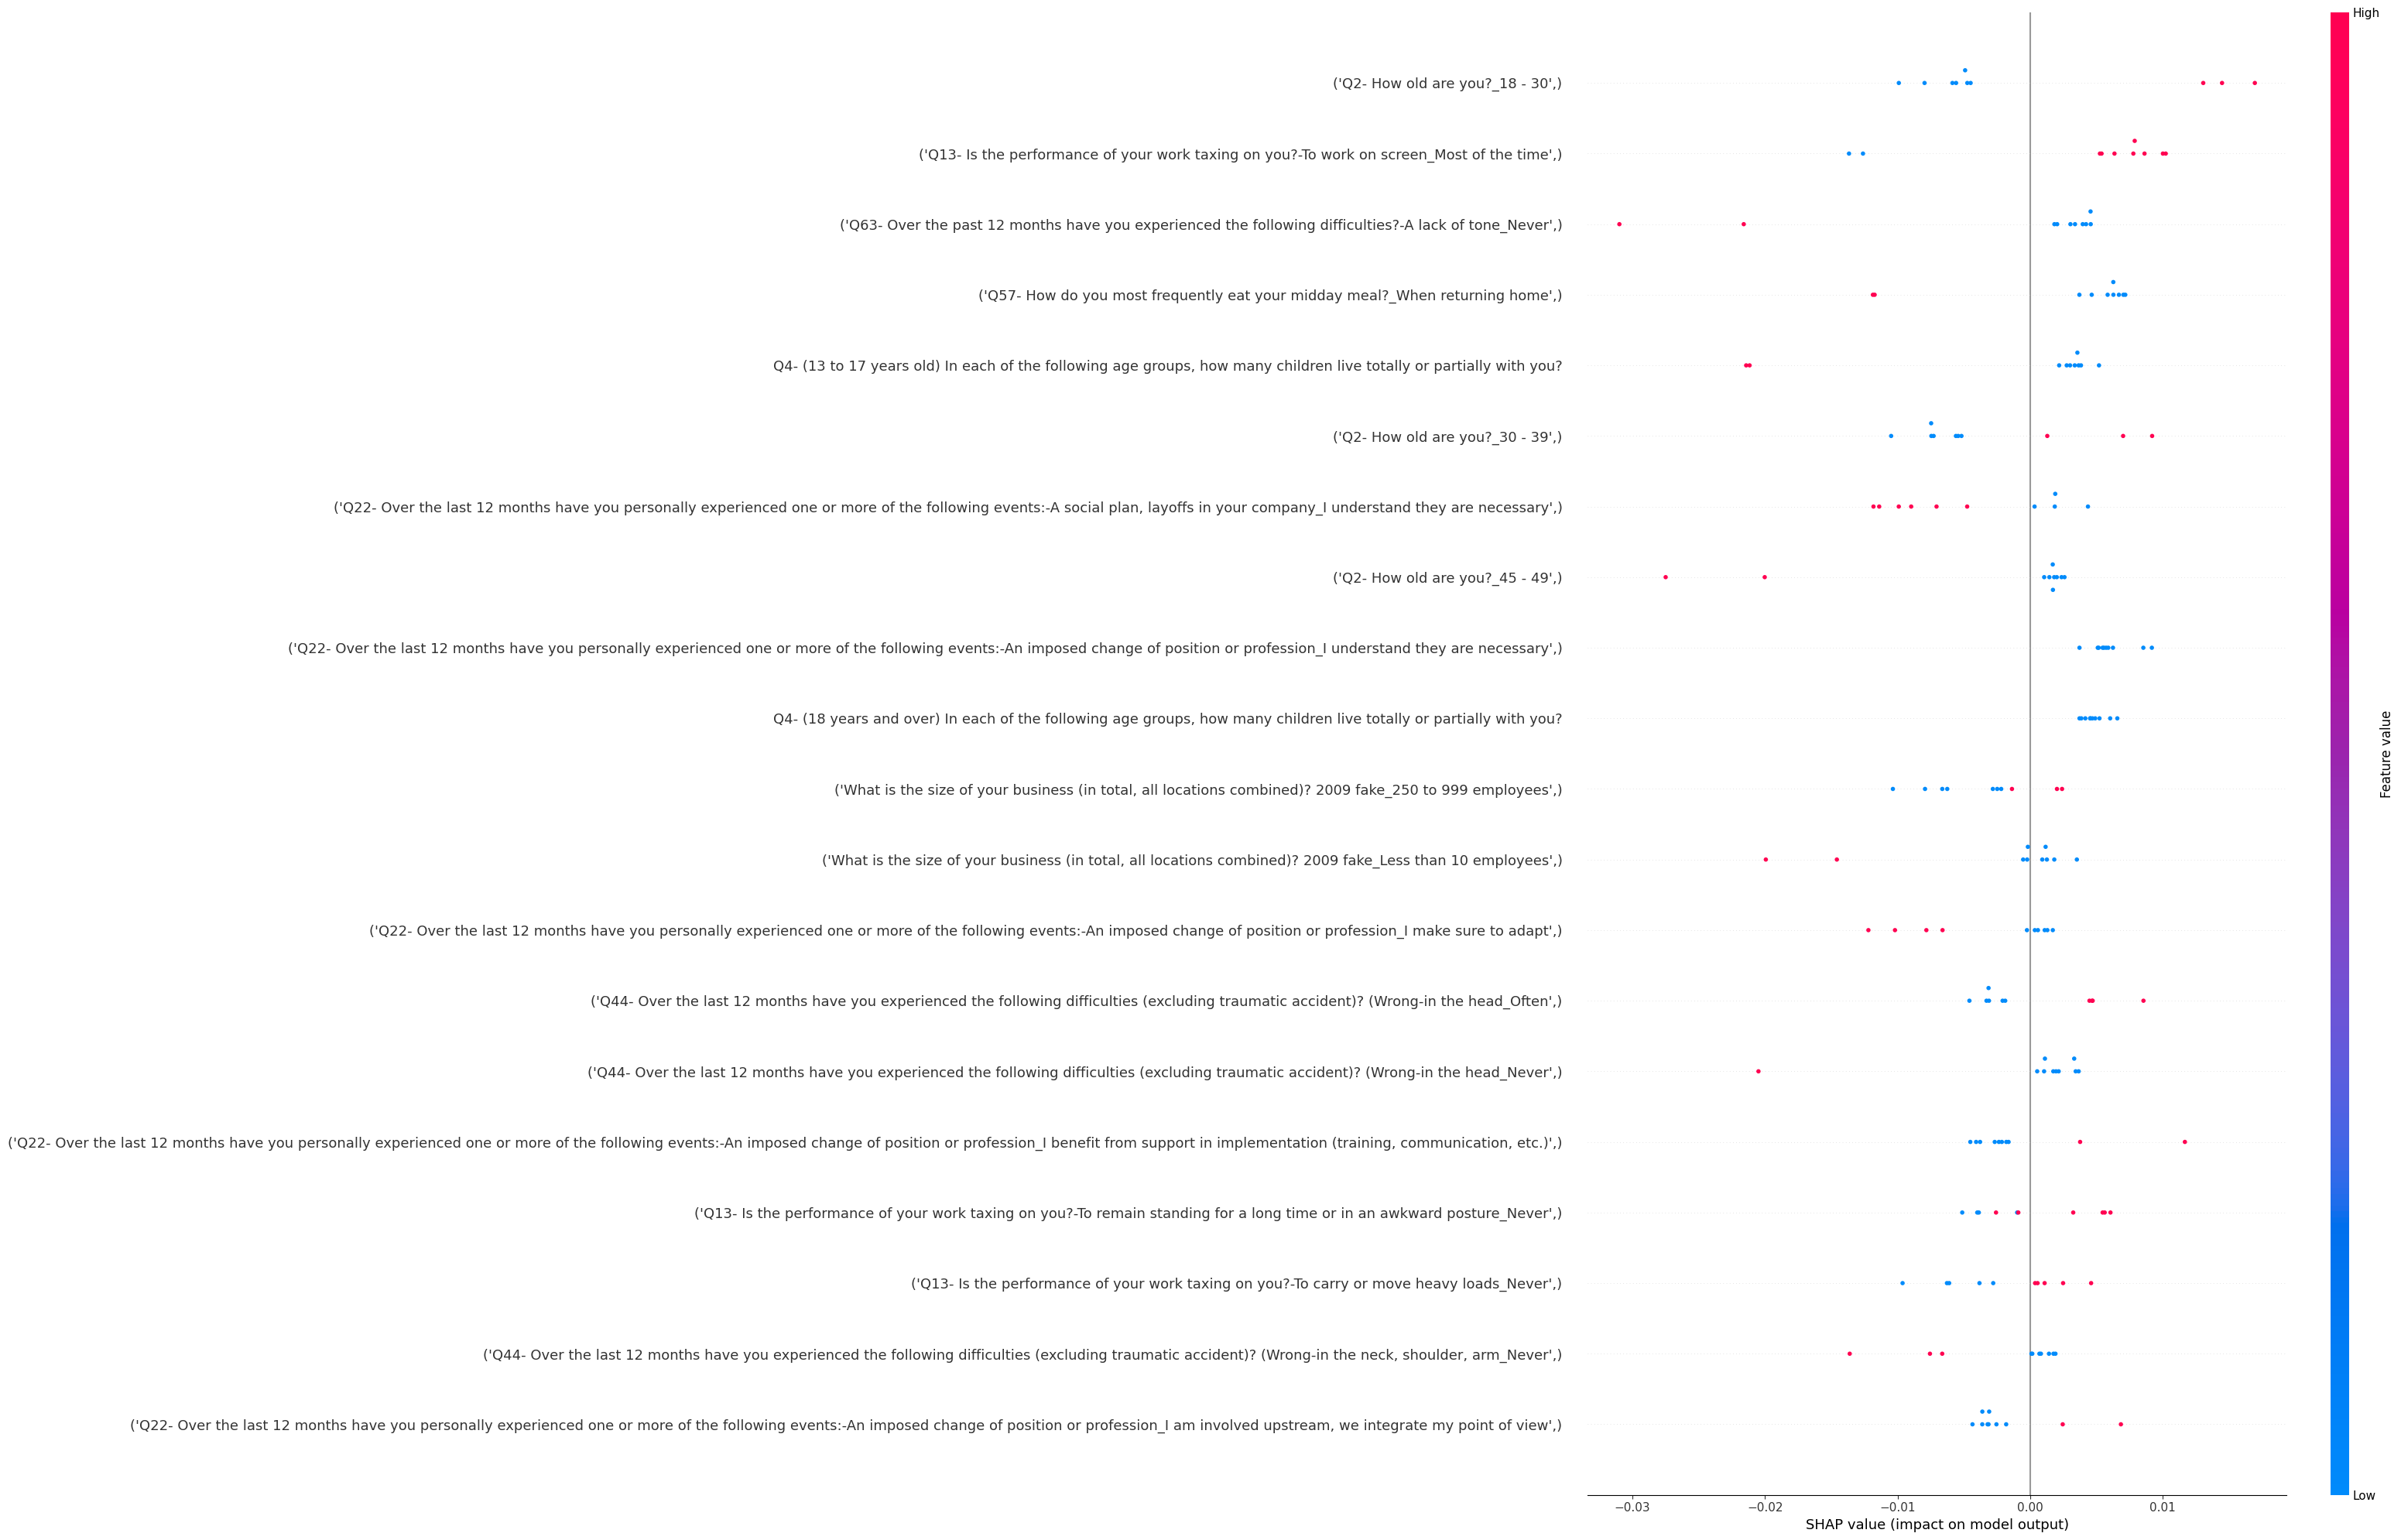

In [12]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_for_10_samples.png')
plt.show()

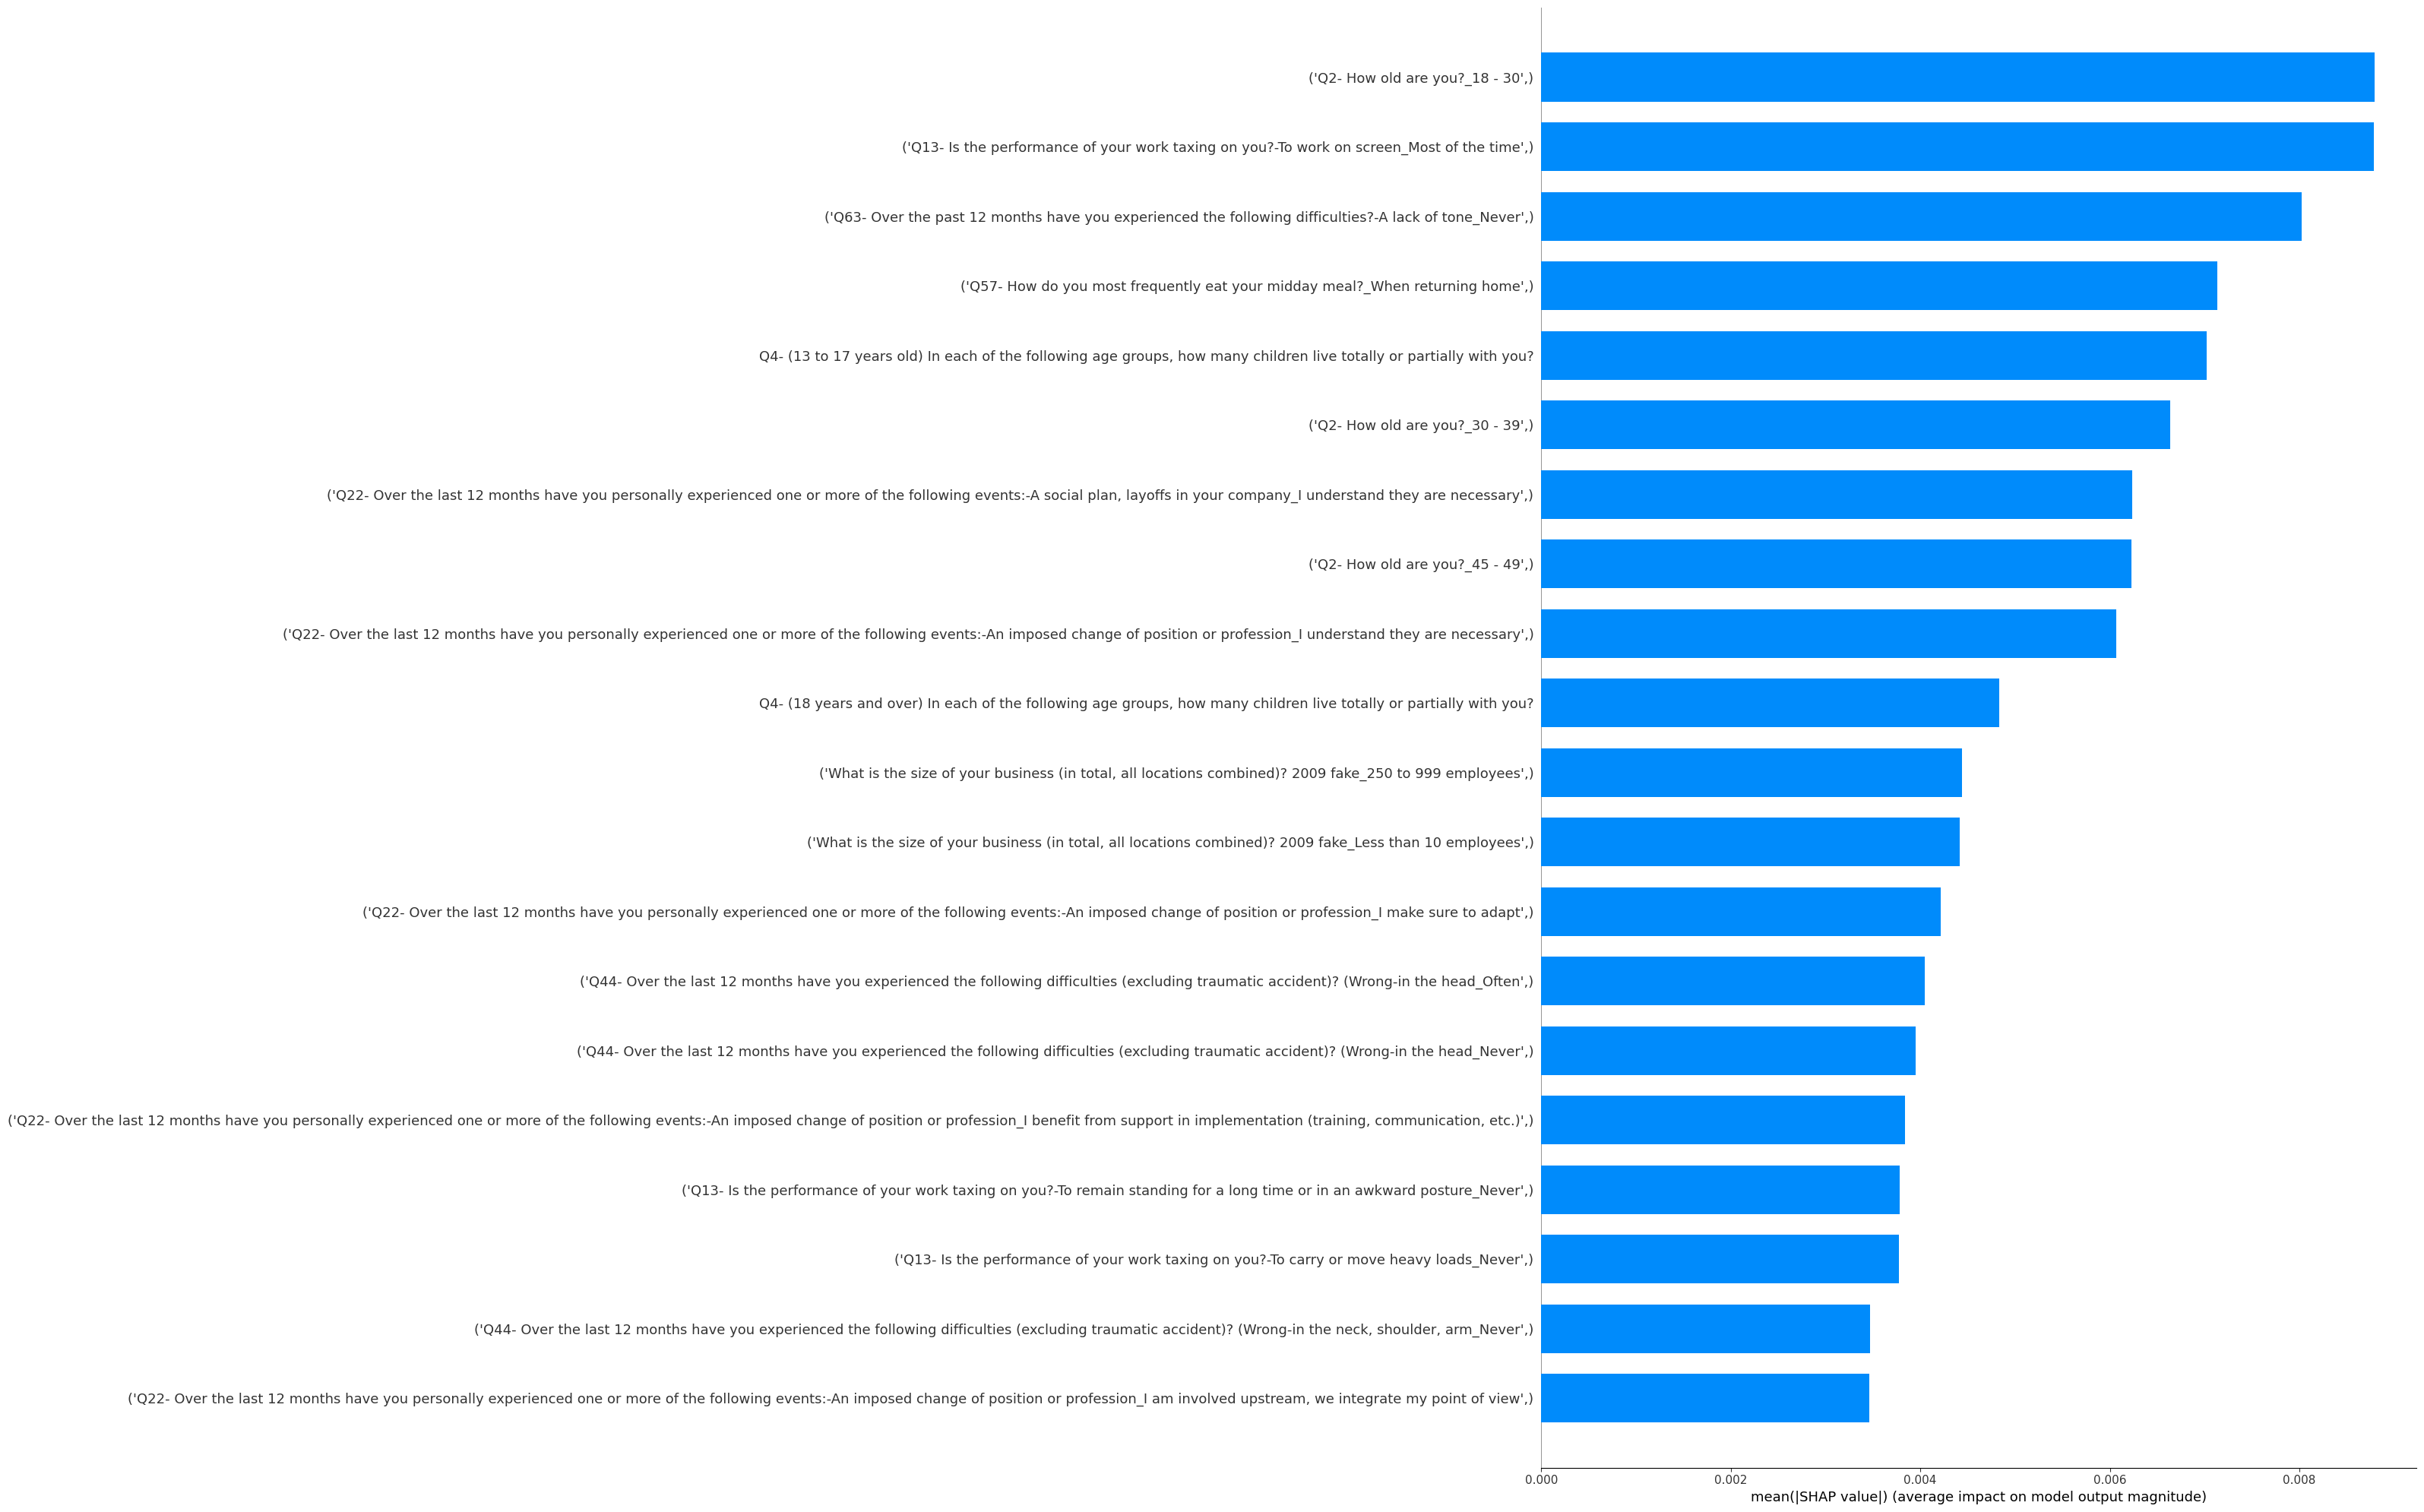

In [13]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_bar_for_10_samples.png')
plt.show()

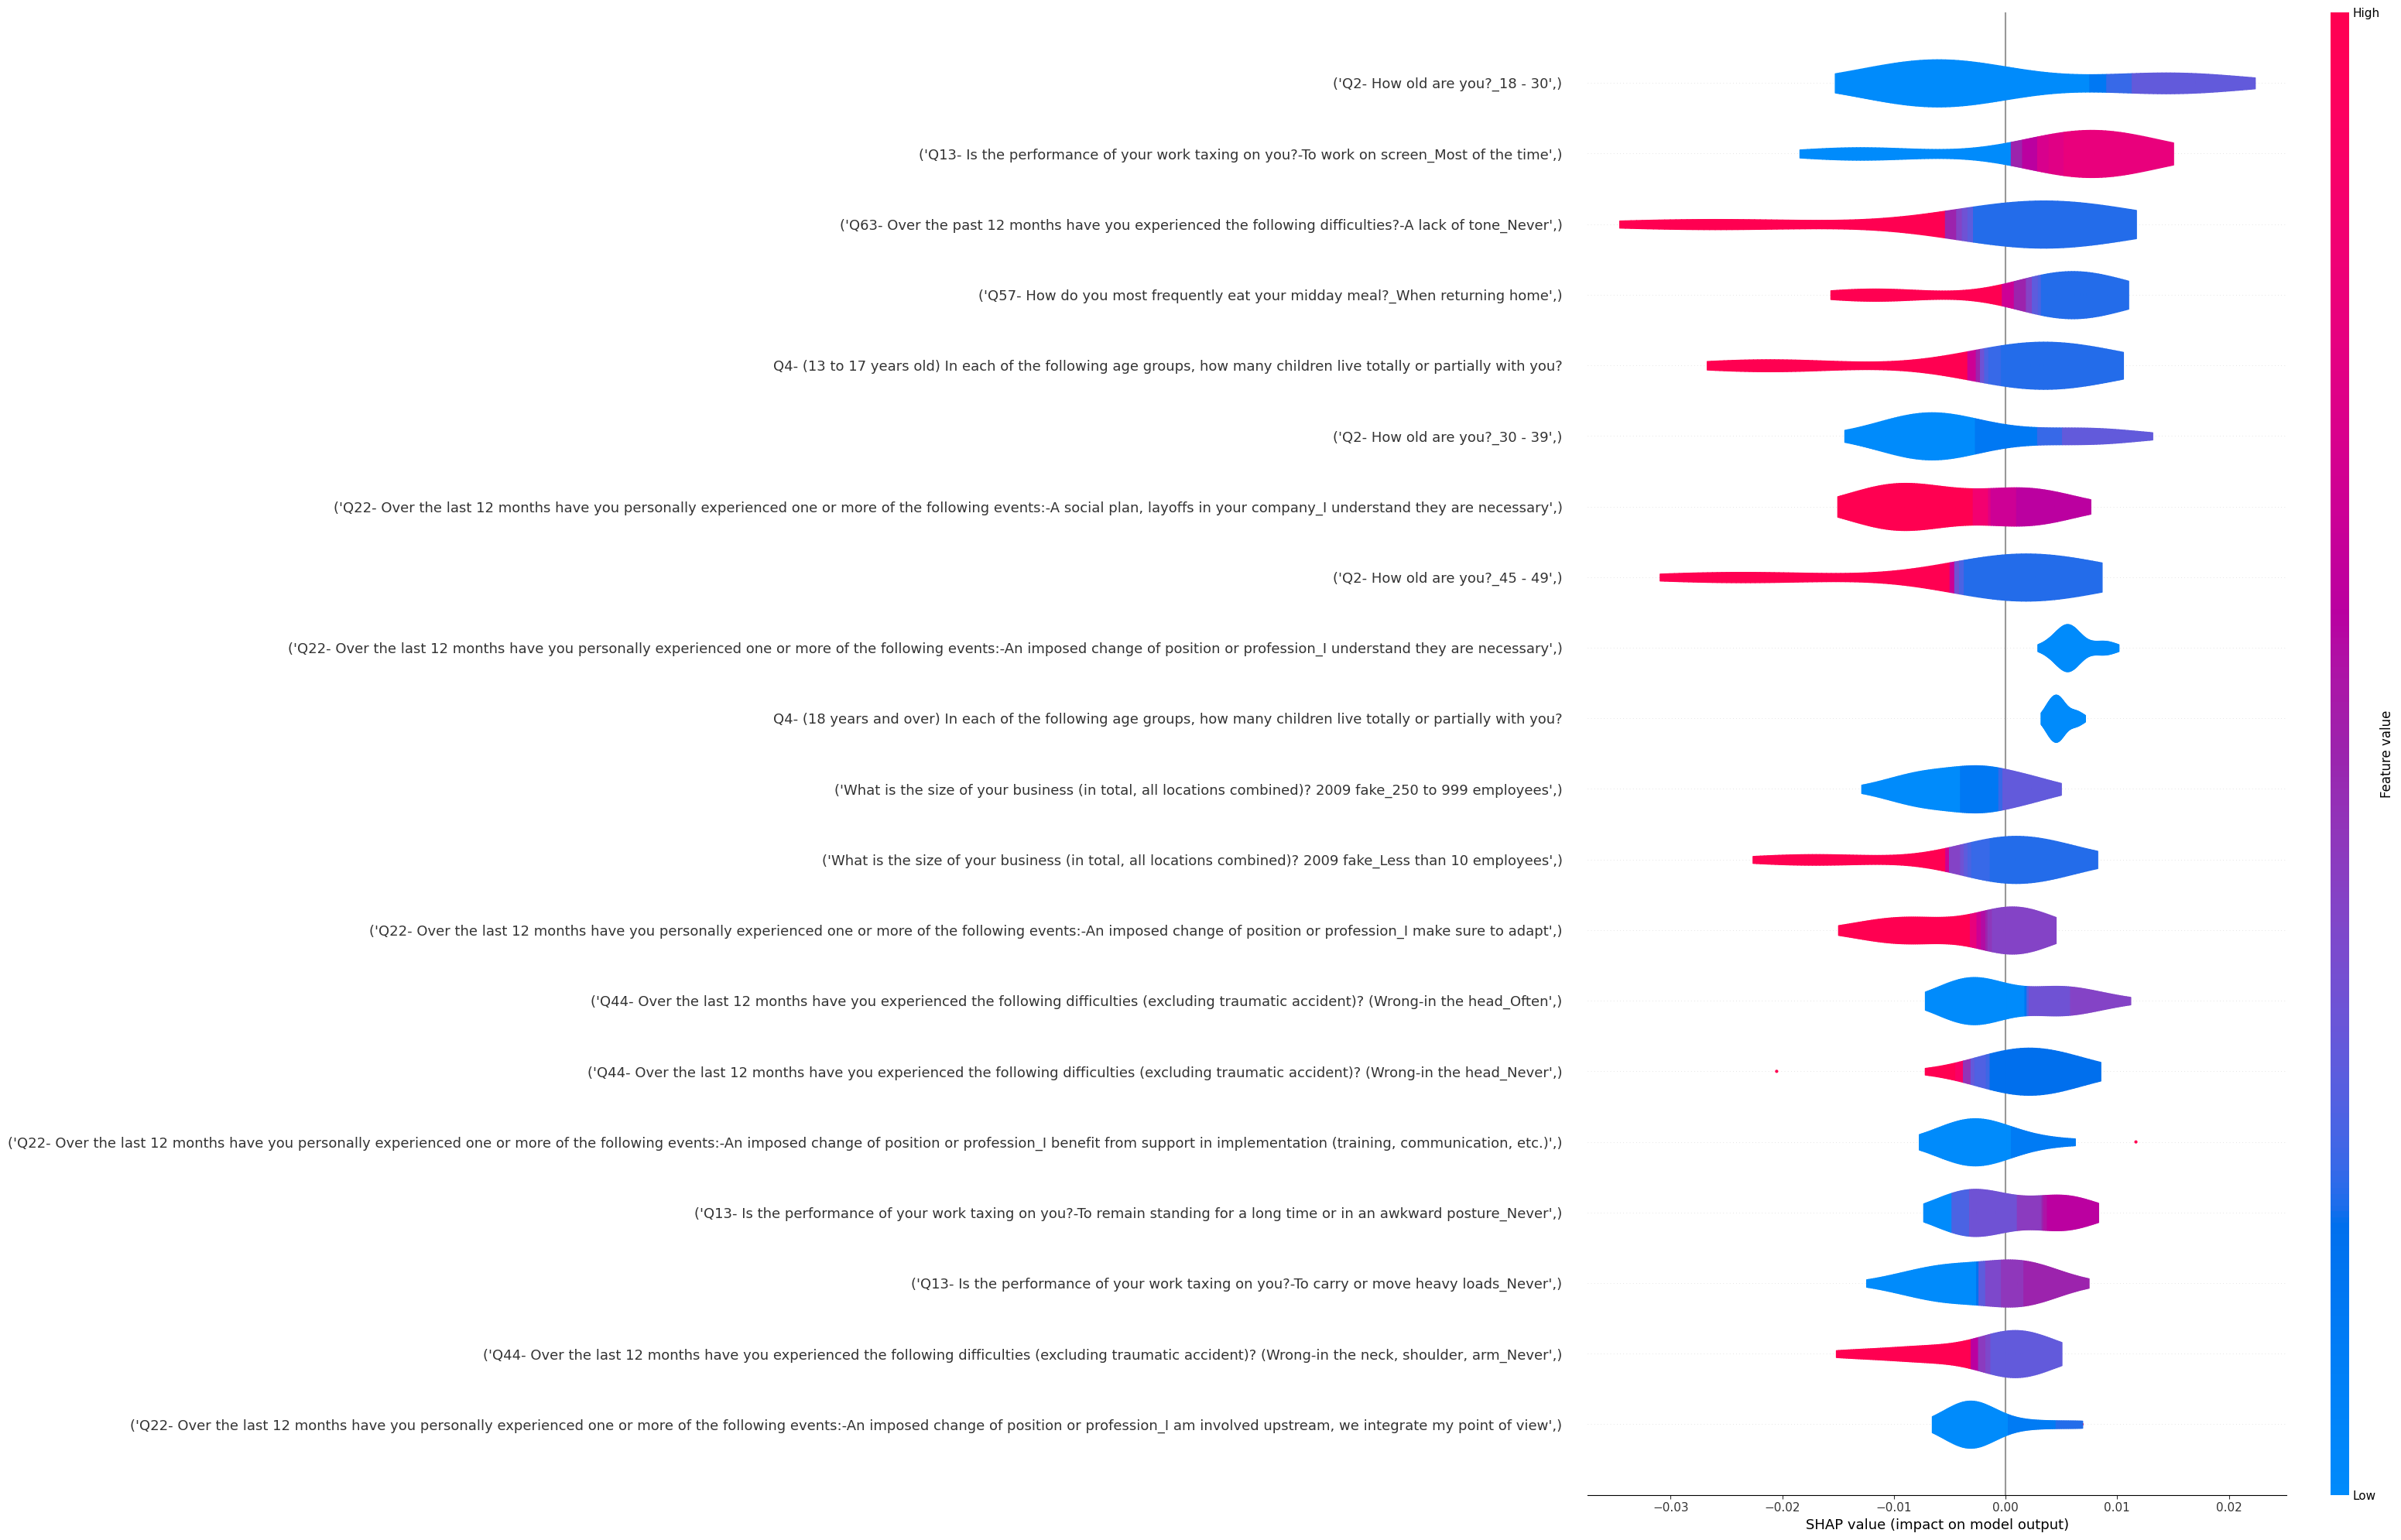

In [14]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_violin_for_10_samples.png')
plt.show()

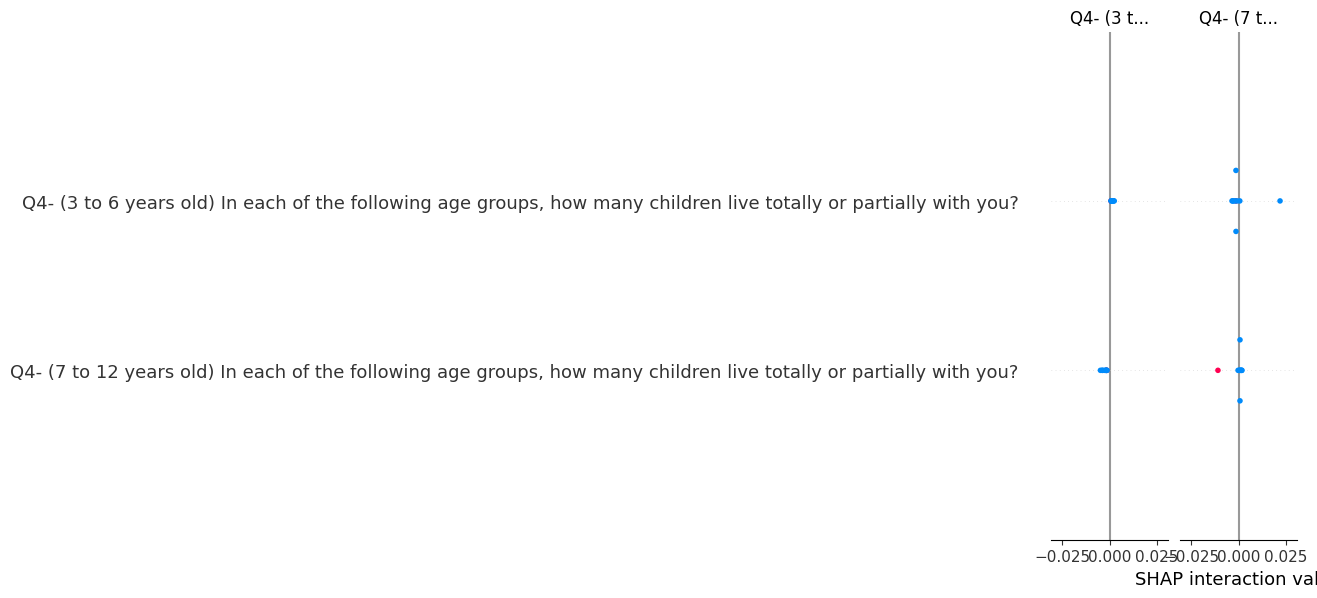

In [15]:
# Shap interaction values

shap.summary_plot(shap_values, X_test[start_index:end_index], plot_type="bar", plot_size=(18,12), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_bar_interaction_for_10_samples.png')
plt.show()

In [16]:
# Calculate shapley values for all data
s_time = time.time()
shap_values_all = explainer.shap_values(X_test)
e_time = time.time()
print(time_e(s_time, e_time, "Shapley values for all data"))

Elapsed time to compute Shapley values for all data: 50 minutes and 10 seconds


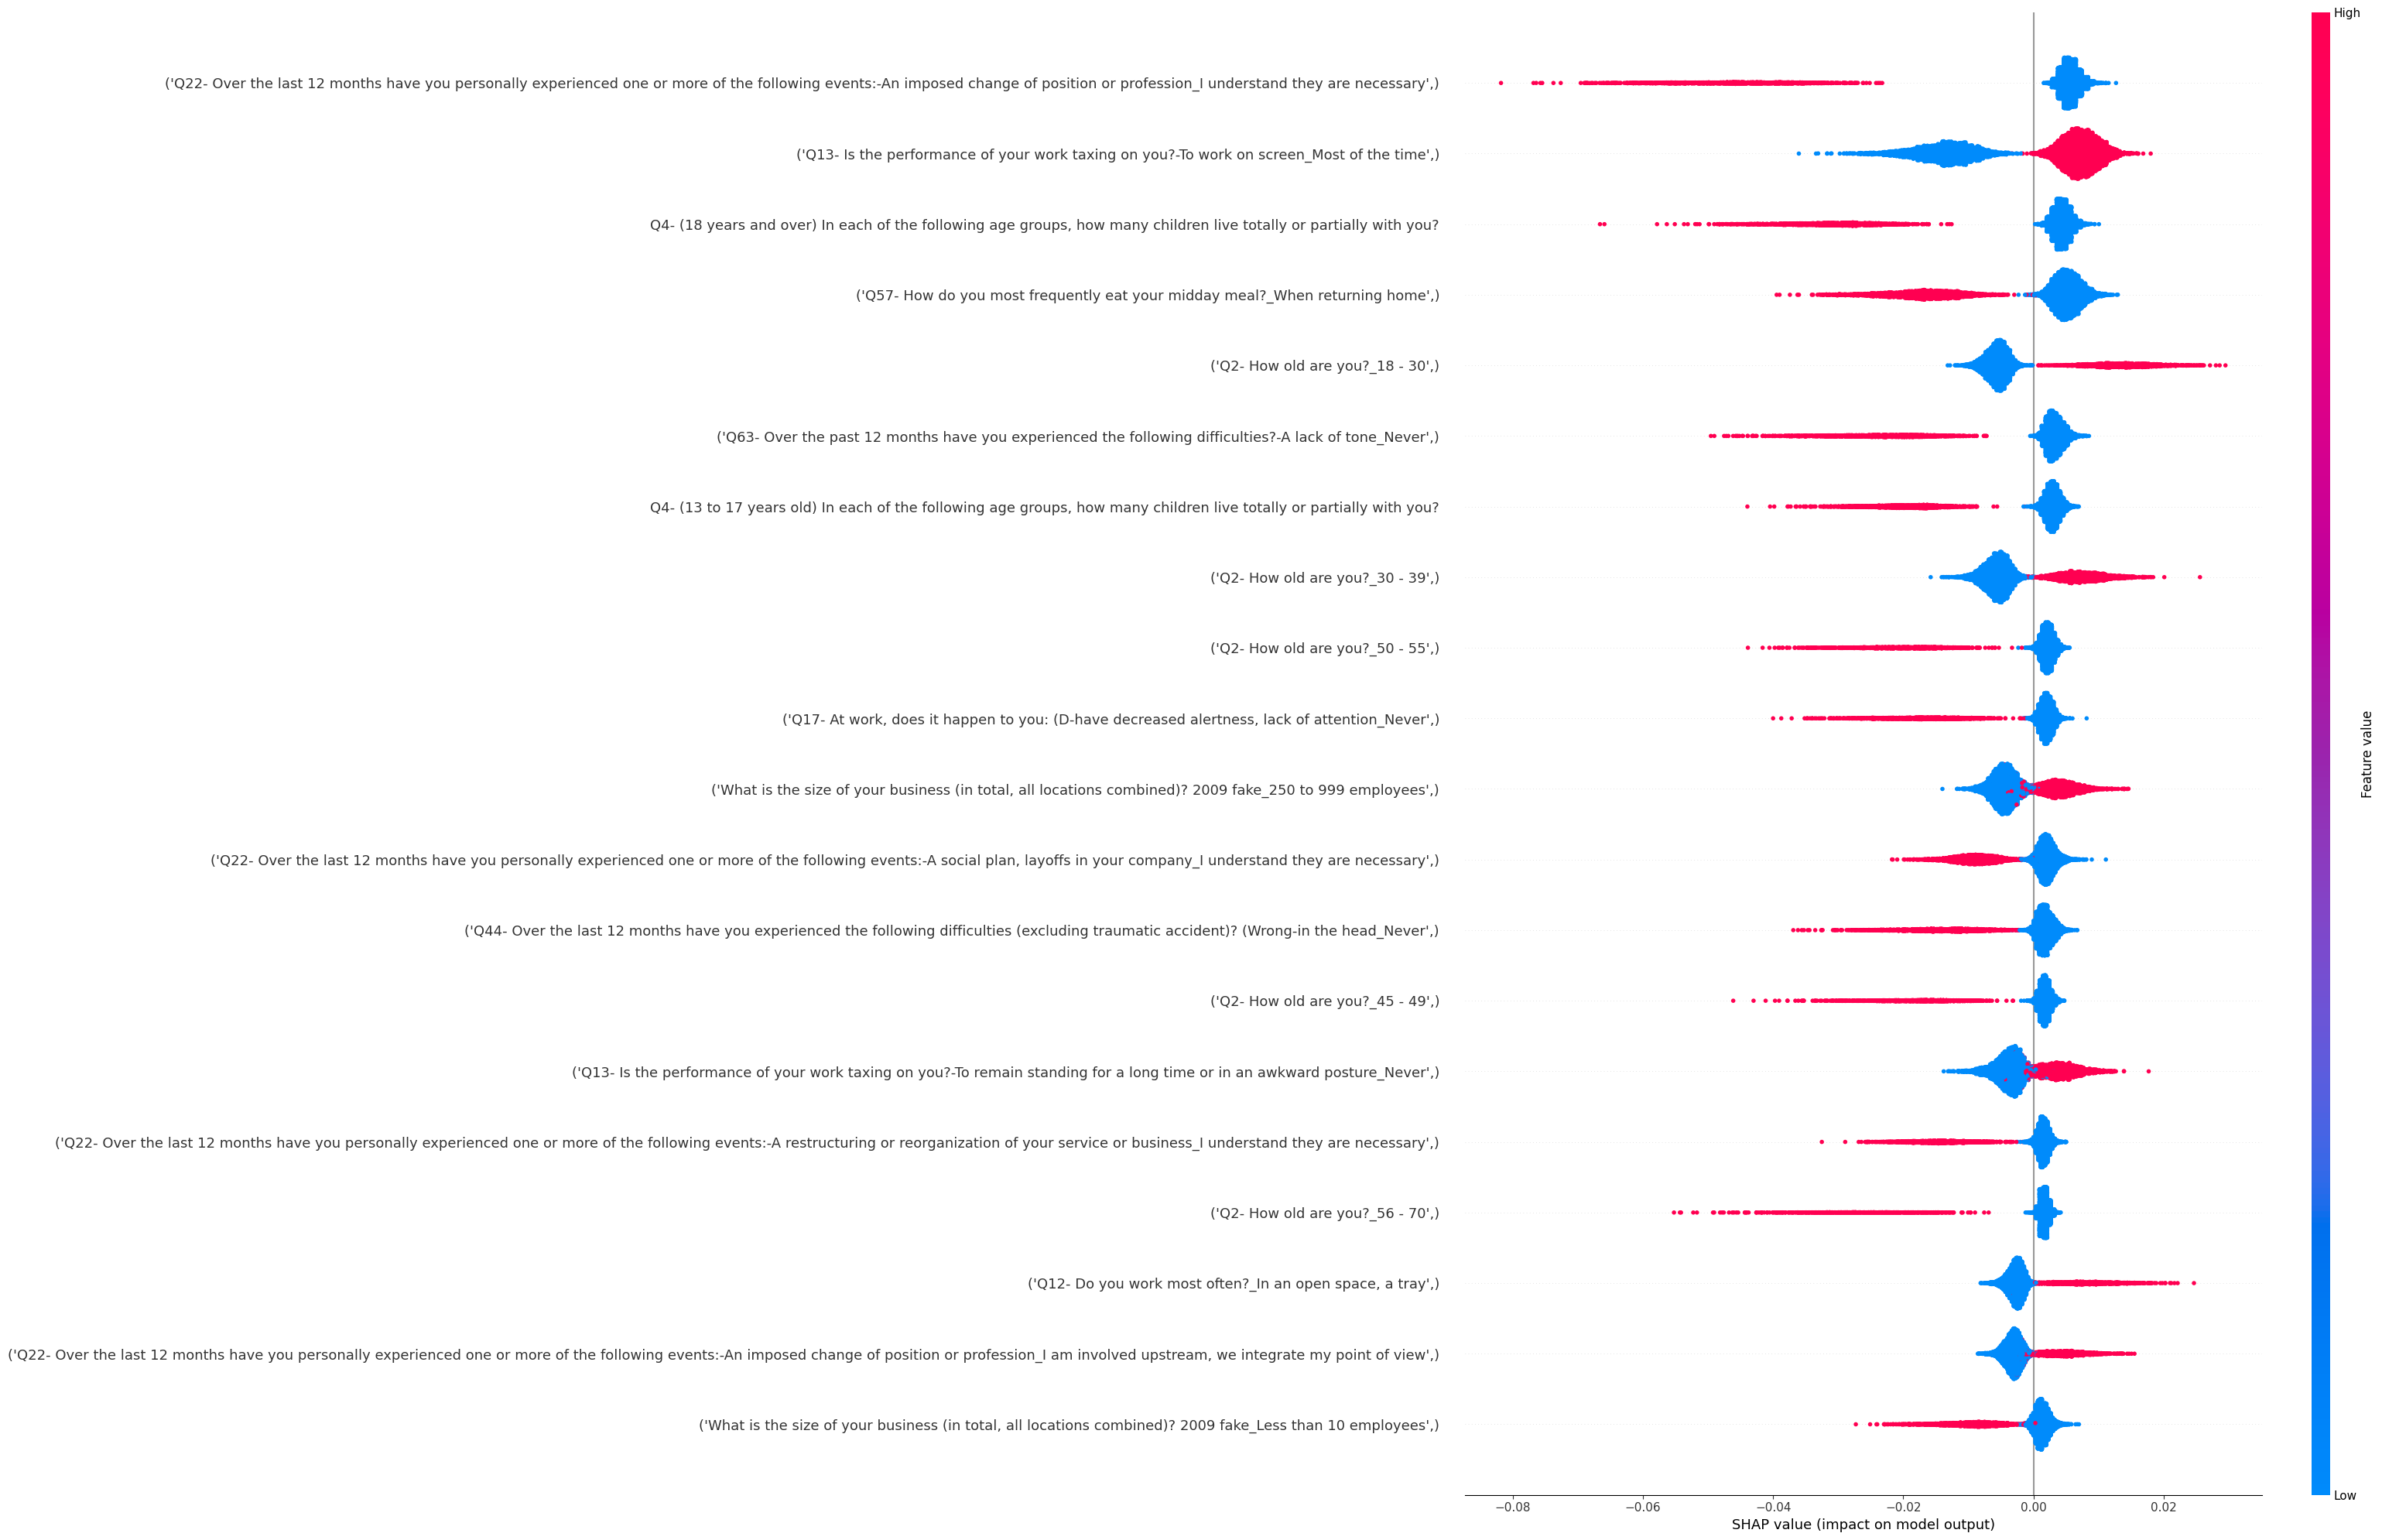

Elapsed time to compute Summary plot for all data: 0 minutes and 2 seconds


In [17]:
s_time = time.time()
shap.summary_plot(shap_values_all[...,1], X_test, plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_all.png')
plt.show()
e_time = time.time()
print(time_e(s_time, e_time, "Summary plot for all data"))

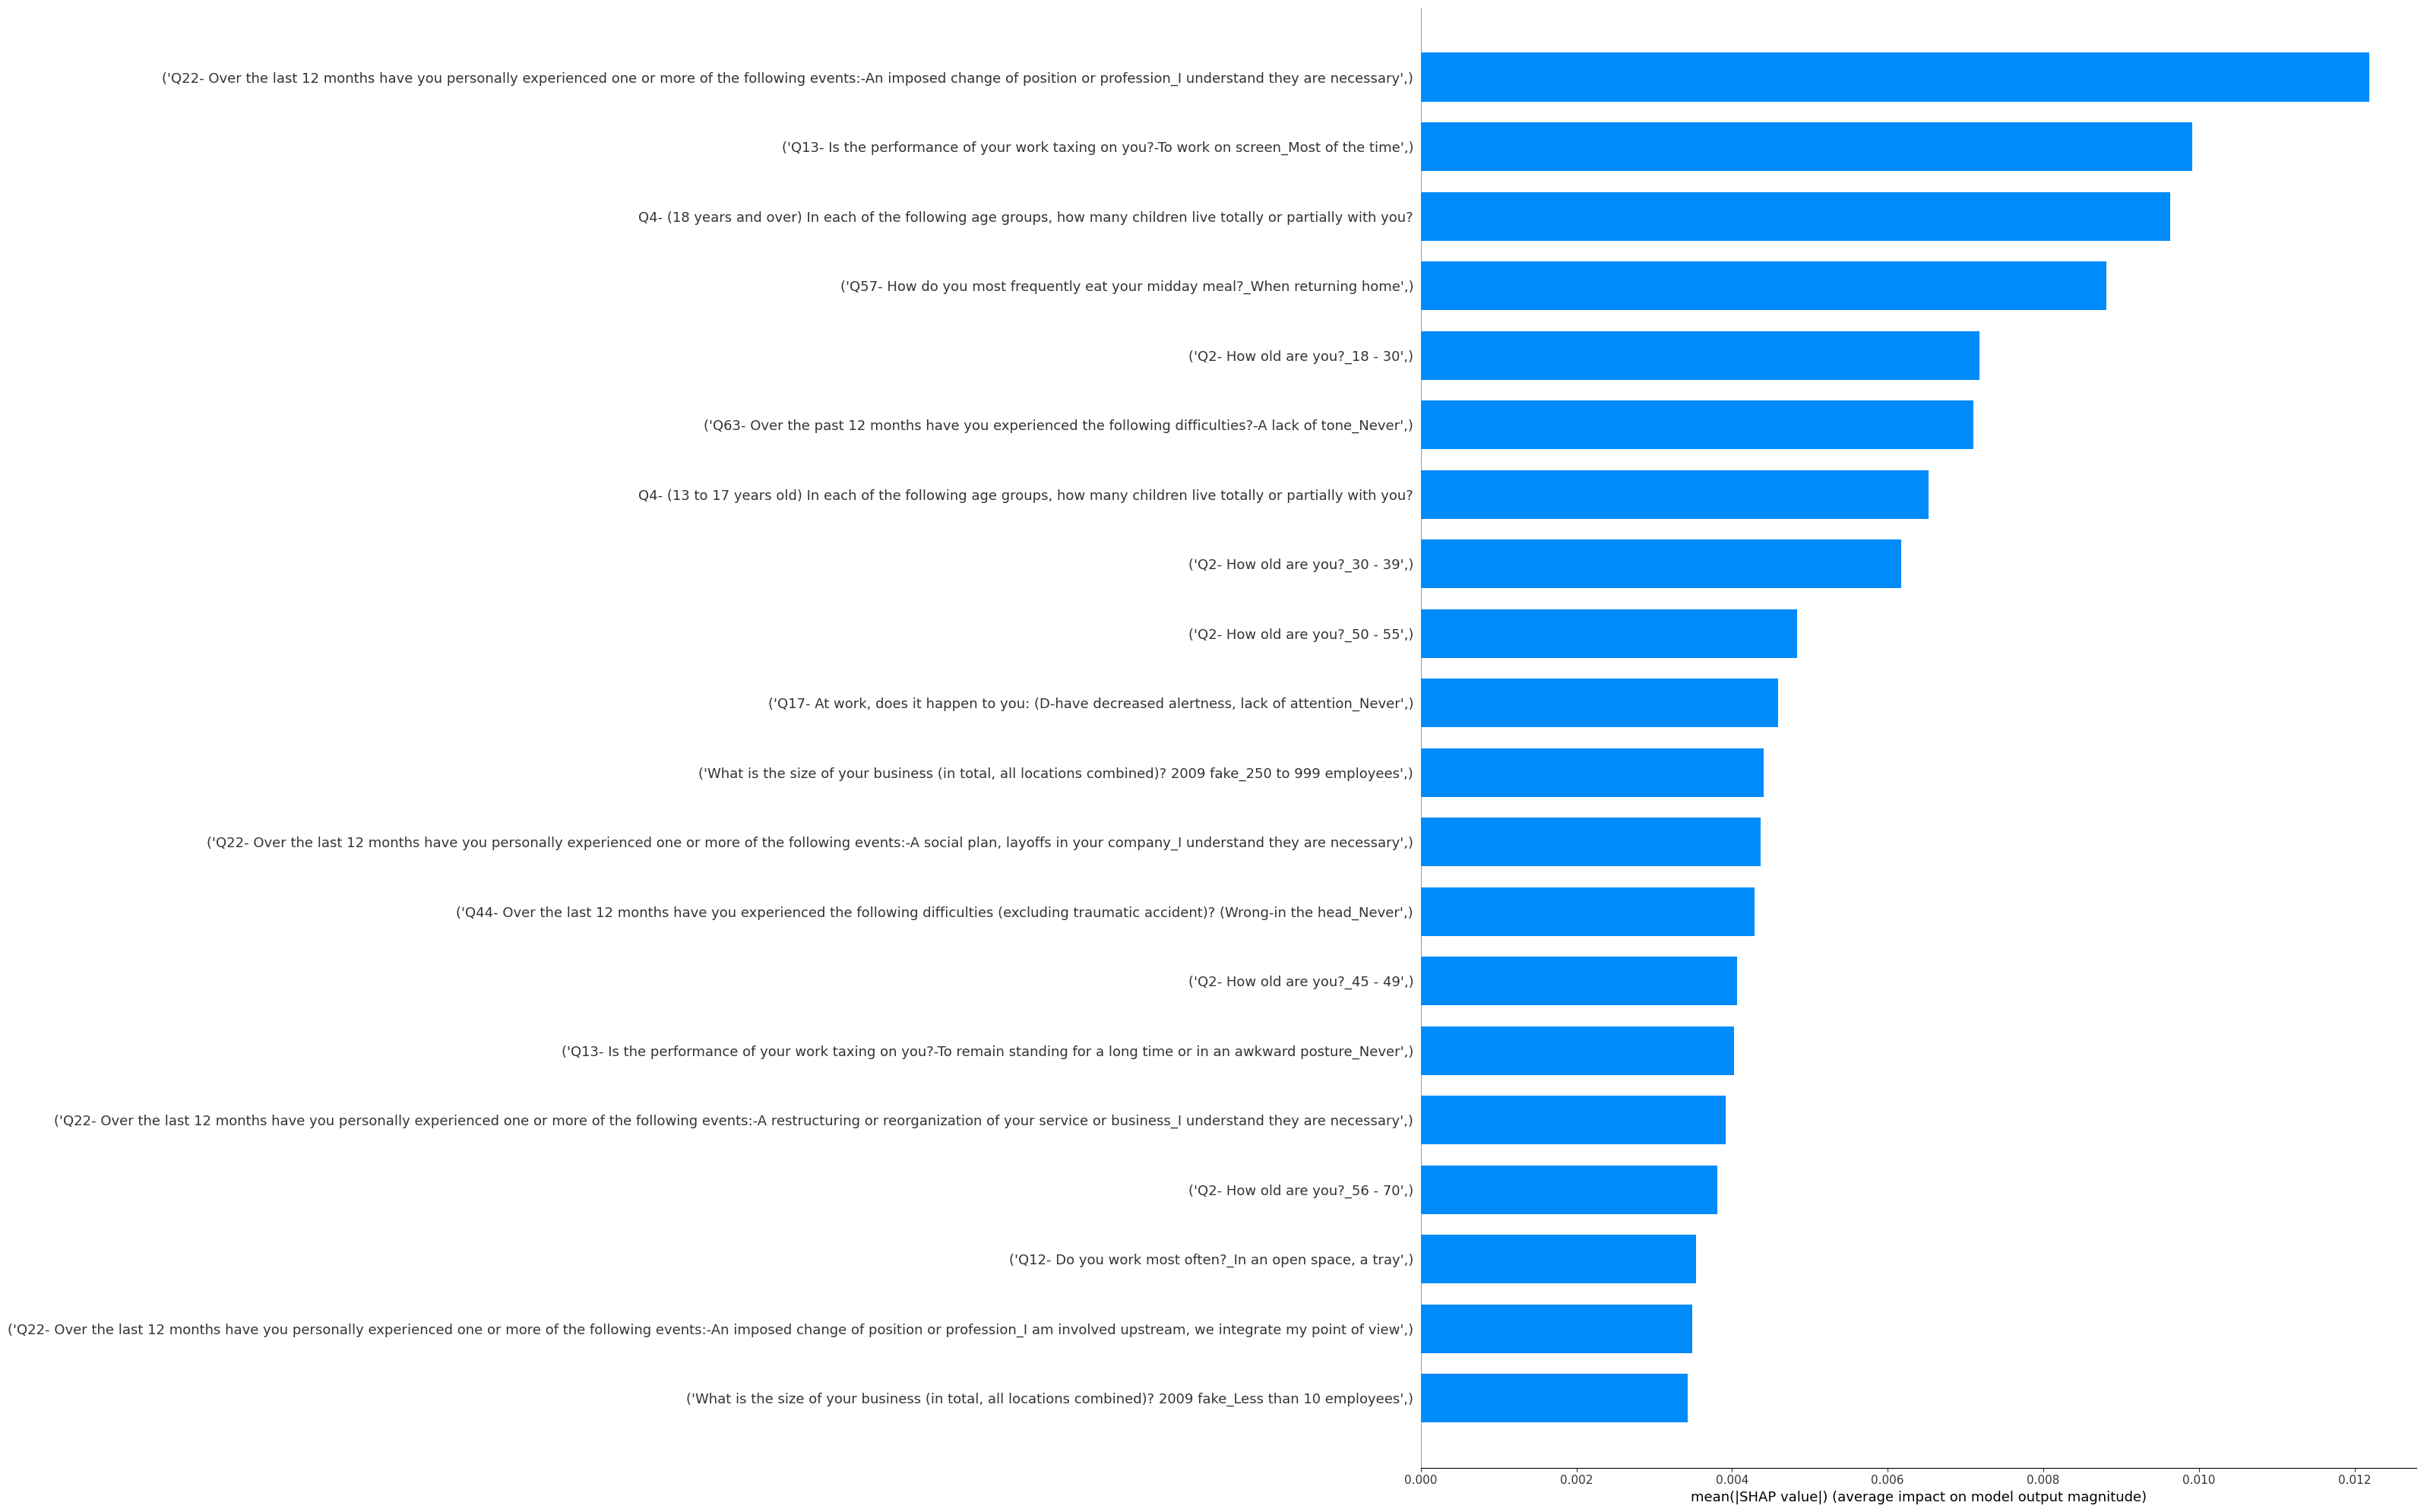

In [18]:
shap.summary_plot(shap_values_all[...,1], X_test, plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_bar_all.png')
plt.show() 

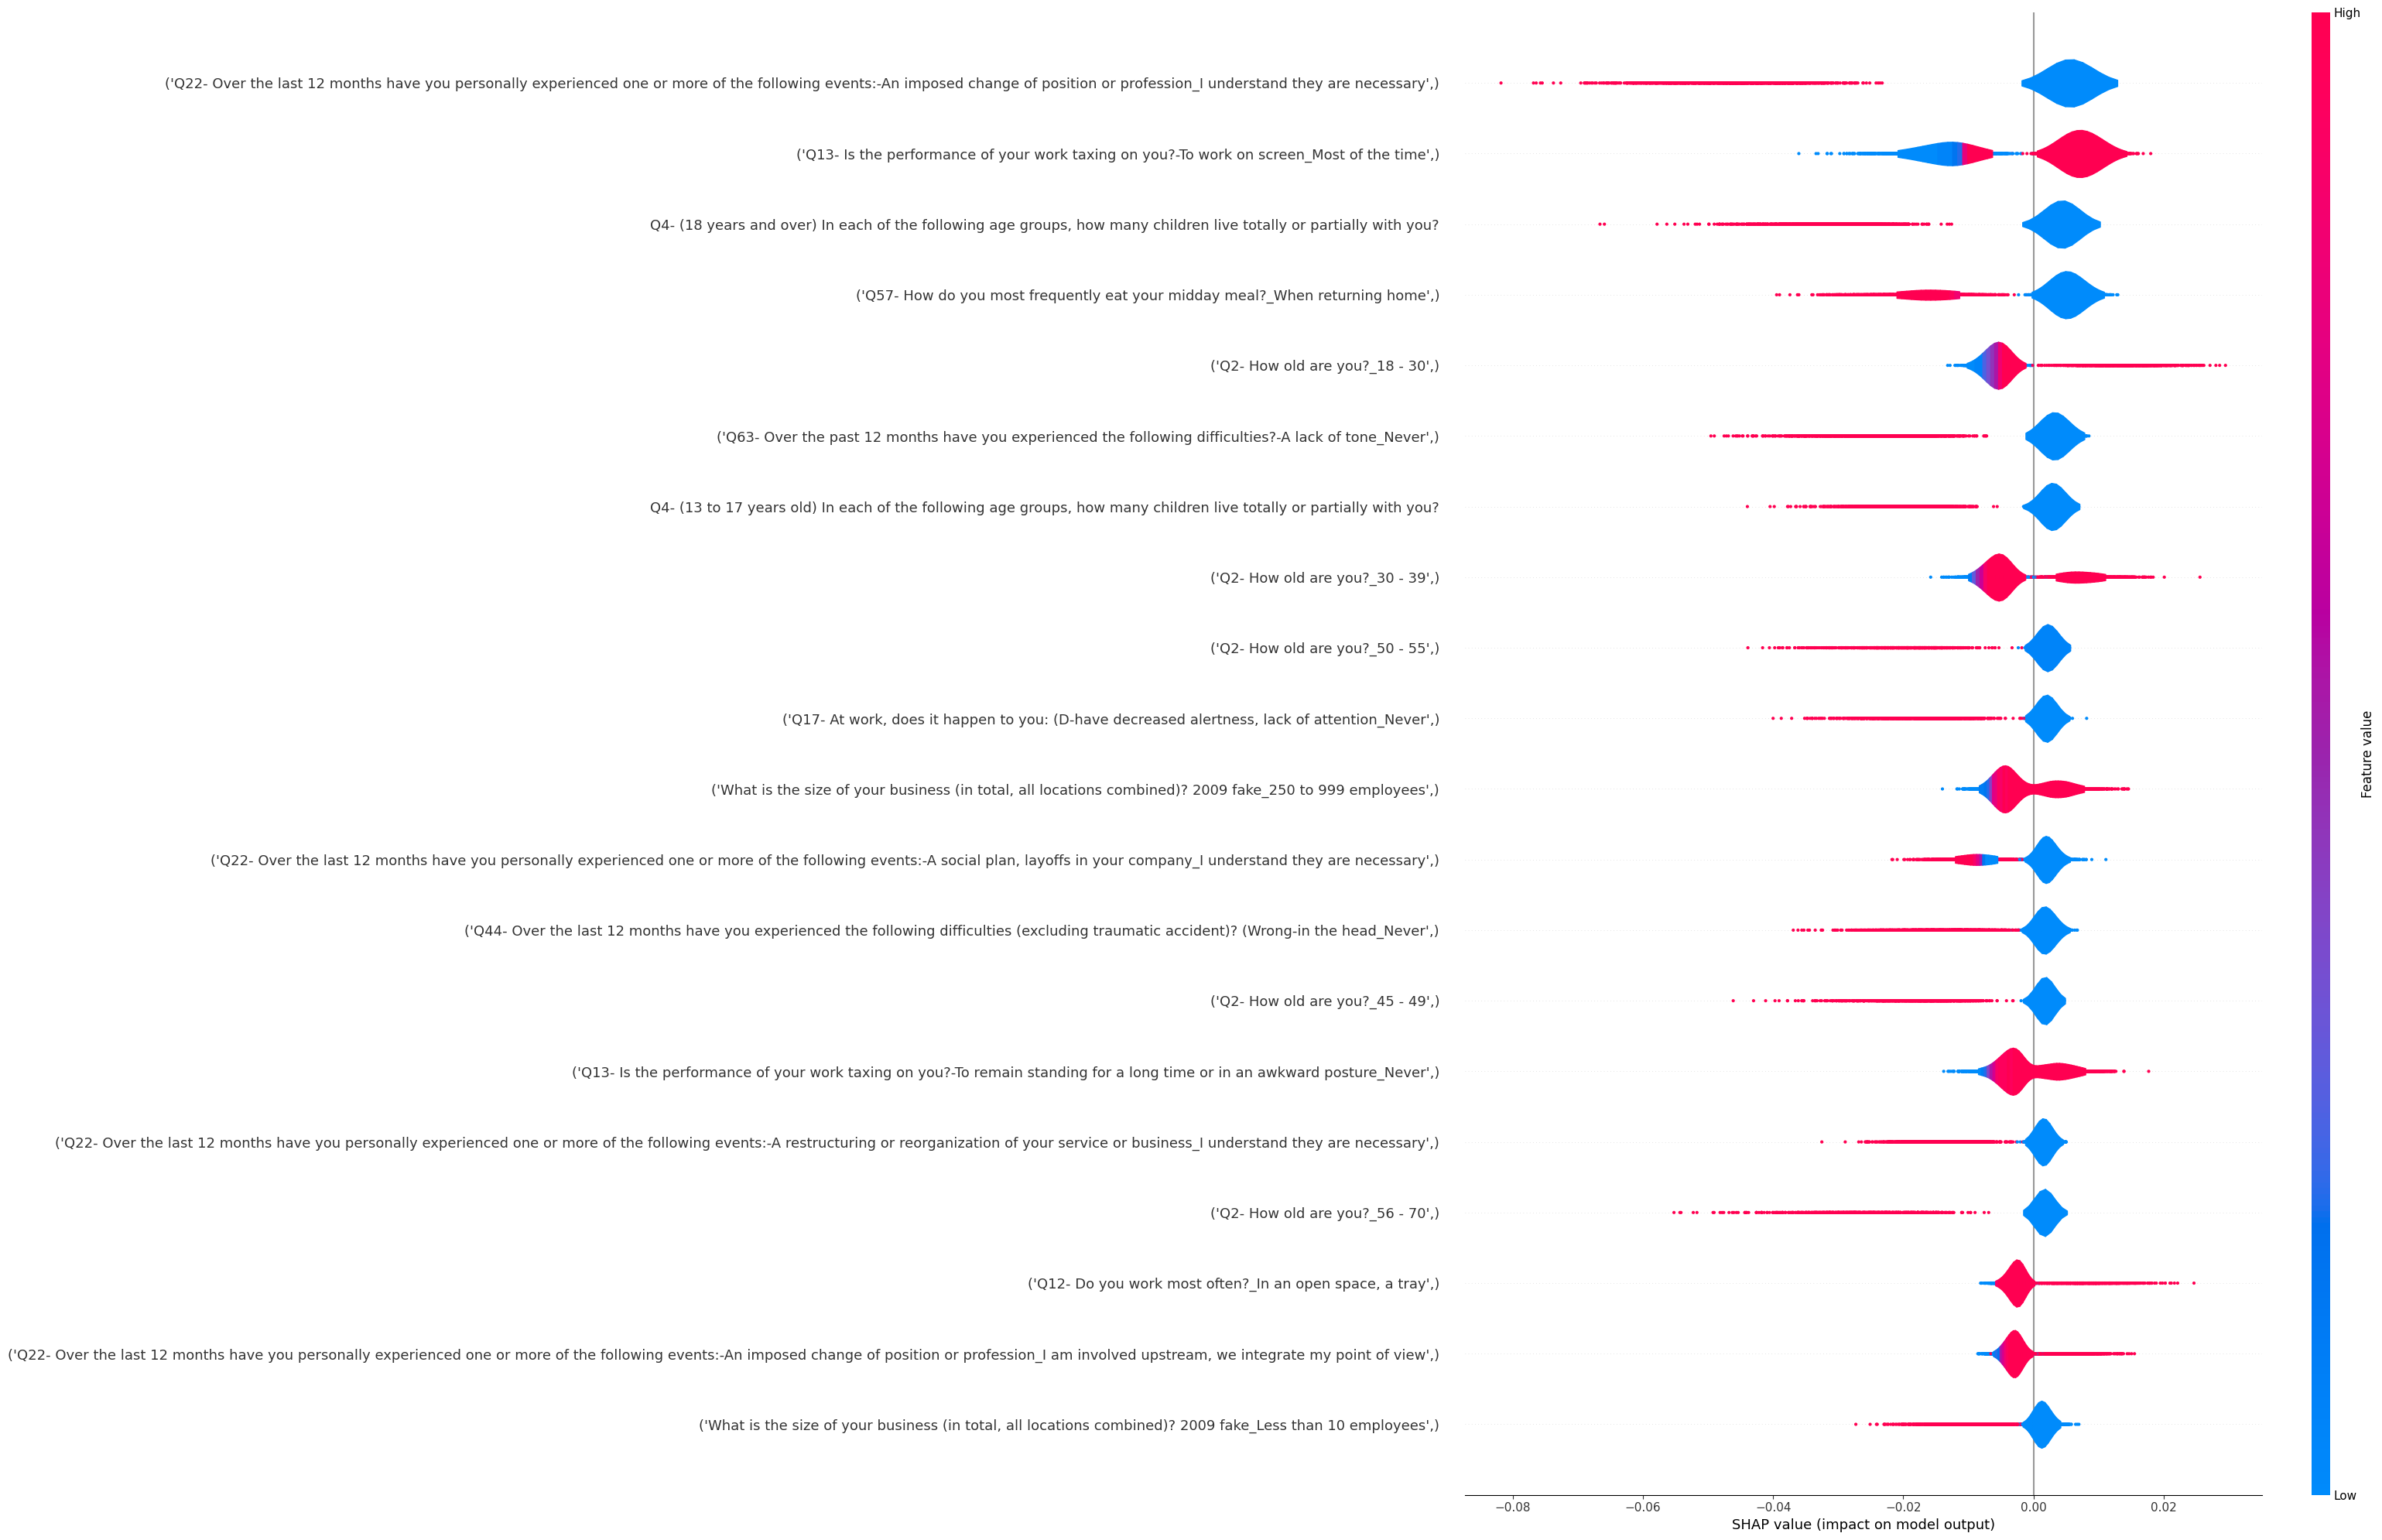

In [19]:
shap.summary_plot(shap_values_all[...,1], X_test, plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_violin_all.png')
plt.show()

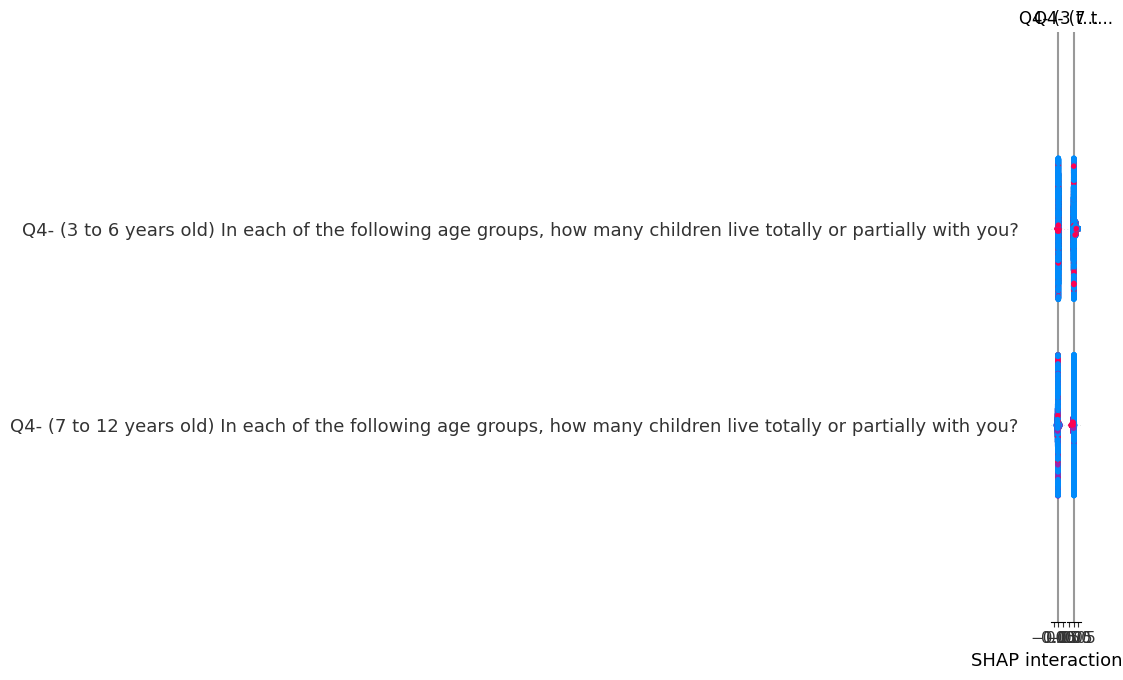

In [20]:
# get the most important feature

shap.summary_plot(shap_values_all, X_test, plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_bar_interaction_all.png')
plt.show()

### XGBoost
max_depth = 3

In [21]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 65.14136298521893
0:[('Q22- Over the last 12 months have you personally experienced one or more of the following events:-An imposed change of position or profession_I understand they are necessary',)<1] yes=1,no=2,missing=2,gain=50.0089111,cover=34791
	1:[('Q13- Is the performance of your work taxing on you?-To work on screen_Most of the time',)<1] yes=3,no=4,missing=4,gain=29.8267212,cover=29073
		3:[('Q2- How old are you?_18 - 30',)<1] yes=7,no=8,missing=8,gain=10.2742615,cover=11760
			7:leaf=0.110995419,cover=9604
			8:leaf=0.187384039,cover=2156
		4:[('Q63- Over the past 12 months have you experienced the following difficulties?-A lack of tone_Never',)<1] yes=9,no=10,missing=10,gain=21.9282227,cover=17313
			9:leaf=0.206439927,cover=14348
			10:leaf=0.111973017,cover=2965
	2:[('Q22- Over the last 12 months have you personally experienced one or more of the following events:-A social plan, layoffs in your company_I understand they are necessary',)<1] yes=5,no=6,missin

In [22]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd) > 0.5
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.46072522788330905
Accuracy 0.8530079618292087


In [23]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

2.9802322e-08

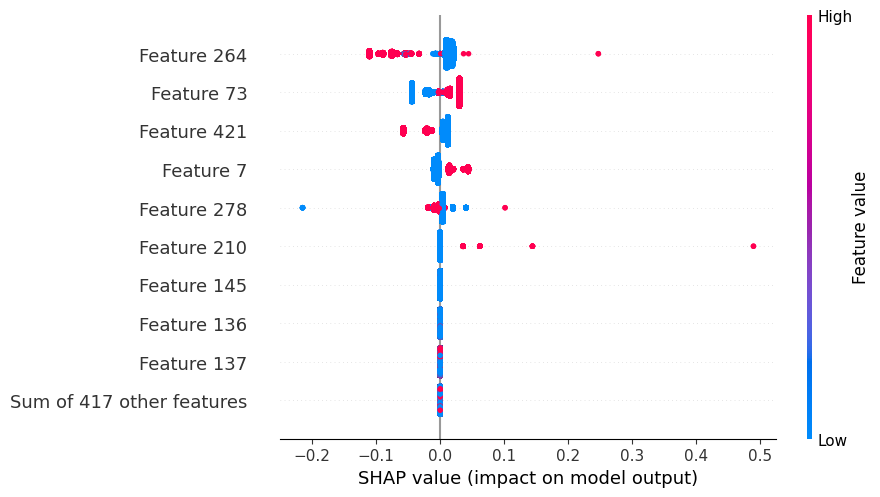

In [24]:
"""
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.
The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution
of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).
"""
shap.plots.beeswarm(explanation, show=False)
plt.savefig('outputs/02_01_shap/shap_beeswarm_plot_xg_4.png')
plt.show()

In [25]:
st = time.time()
clustering = shap.utils.hclust(X, y)
et = time.time()
print(time_e(st, et, "Clustering"))

427it [04:30,  1.56it/s]                         

Elapsed time to compute Clustering: 4 minutes and 35 seconds


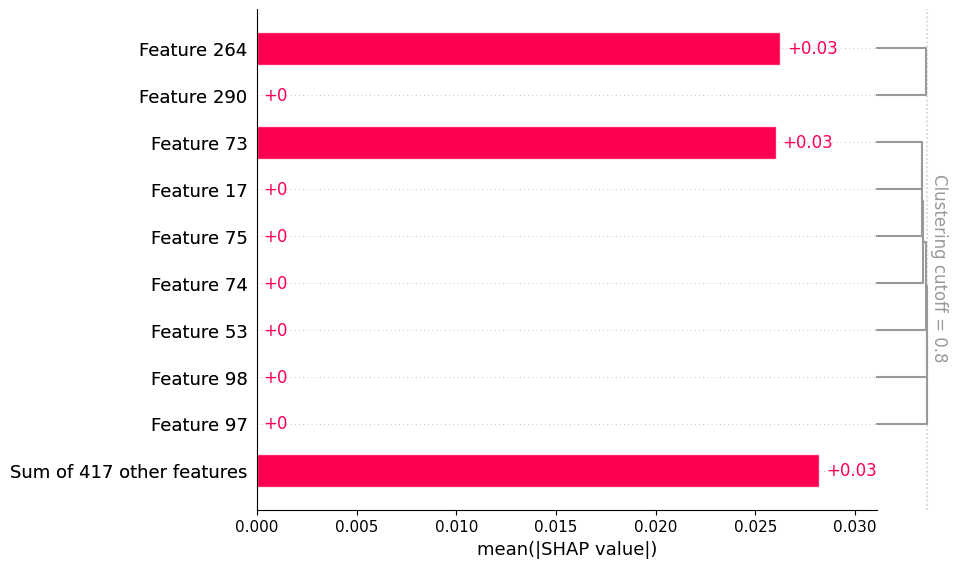

In [26]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=0.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3.png')
plt.show()

### XGBoost

max_depth = 4

In [27]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y) 
model = xgboost.train({"eta": 1, "max_depth": 4, "base_score": 0, "lambda": 0}, Xd, 1)
baseline_error = np.linalg.norm(y - model.predict(Xd))
print("Baseline Model error =", baseline_error)
print(model.get_dump(with_stats=True)[0])

Baseline Model error = 64.91178103348464
0:[('Q22- Over the last 12 months have you personally experienced one or more of the following events:-An imposed change of position or profession_I understand they are necessary',)<1] yes=1,no=2,missing=2,gain=50.0089111,cover=34791
	1:[('Q13- Is the performance of your work taxing on you?-To work on screen_Most of the time',)<1] yes=3,no=4,missing=4,gain=29.8267212,cover=29073
		3:[('Q2- How old are you?_18 - 30',)<1] yes=7,no=8,missing=8,gain=10.2742615,cover=11760
			7:[('Q2- How old are you?_30 - 39',)<1] yes=15,no=16,missing=16,gain=9.1856842,cover=9604
				15:leaf=0.0900955573,cover=6593
				16:leaf=0.156758547,cover=3011
			8:[('Q42-During the last 12 months have you had a work accident?_No',)<1] yes=17,no=18,missing=18,gain=3.16899109,cover=2156
				17:leaf=0.341269851,cover=126
				18:leaf=0.177832514,cover=2030
		4:[('Q63- Over the past 12 months have you experienced the following difficulties?-A lack of tone_Never',)<1] yes=9,no=10,m

In [28]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd)
y_pred = [1 if i > 0.5 else 0 for i in y_pred] # convert to binary
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.46072522788330905
Accuracy 0.8530079618292087


In [29]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

1.1920929e-07

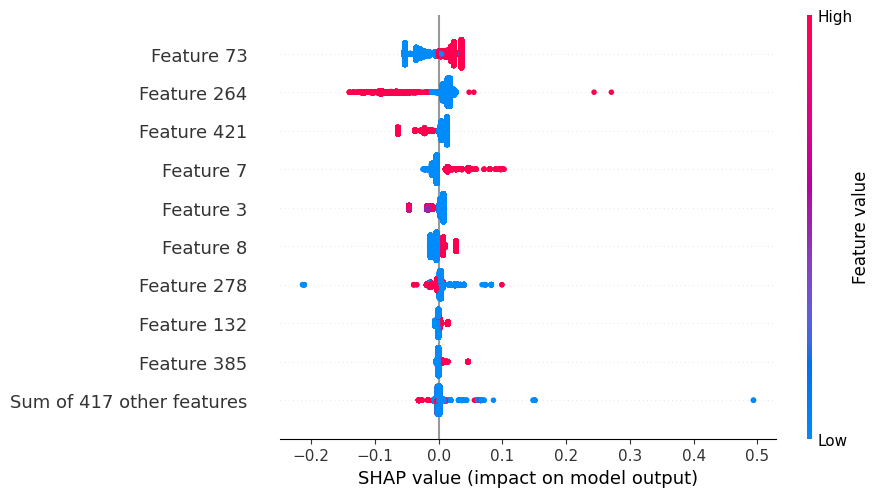

In [30]:
shap.plots.beeswarm(explanation, show=False) # plot the SHAP values
plt.figsize=(32,12)
plt.savefig('outputs/02_01_shap/shap_beeswarm_plot_xg_4.png')
plt.show()

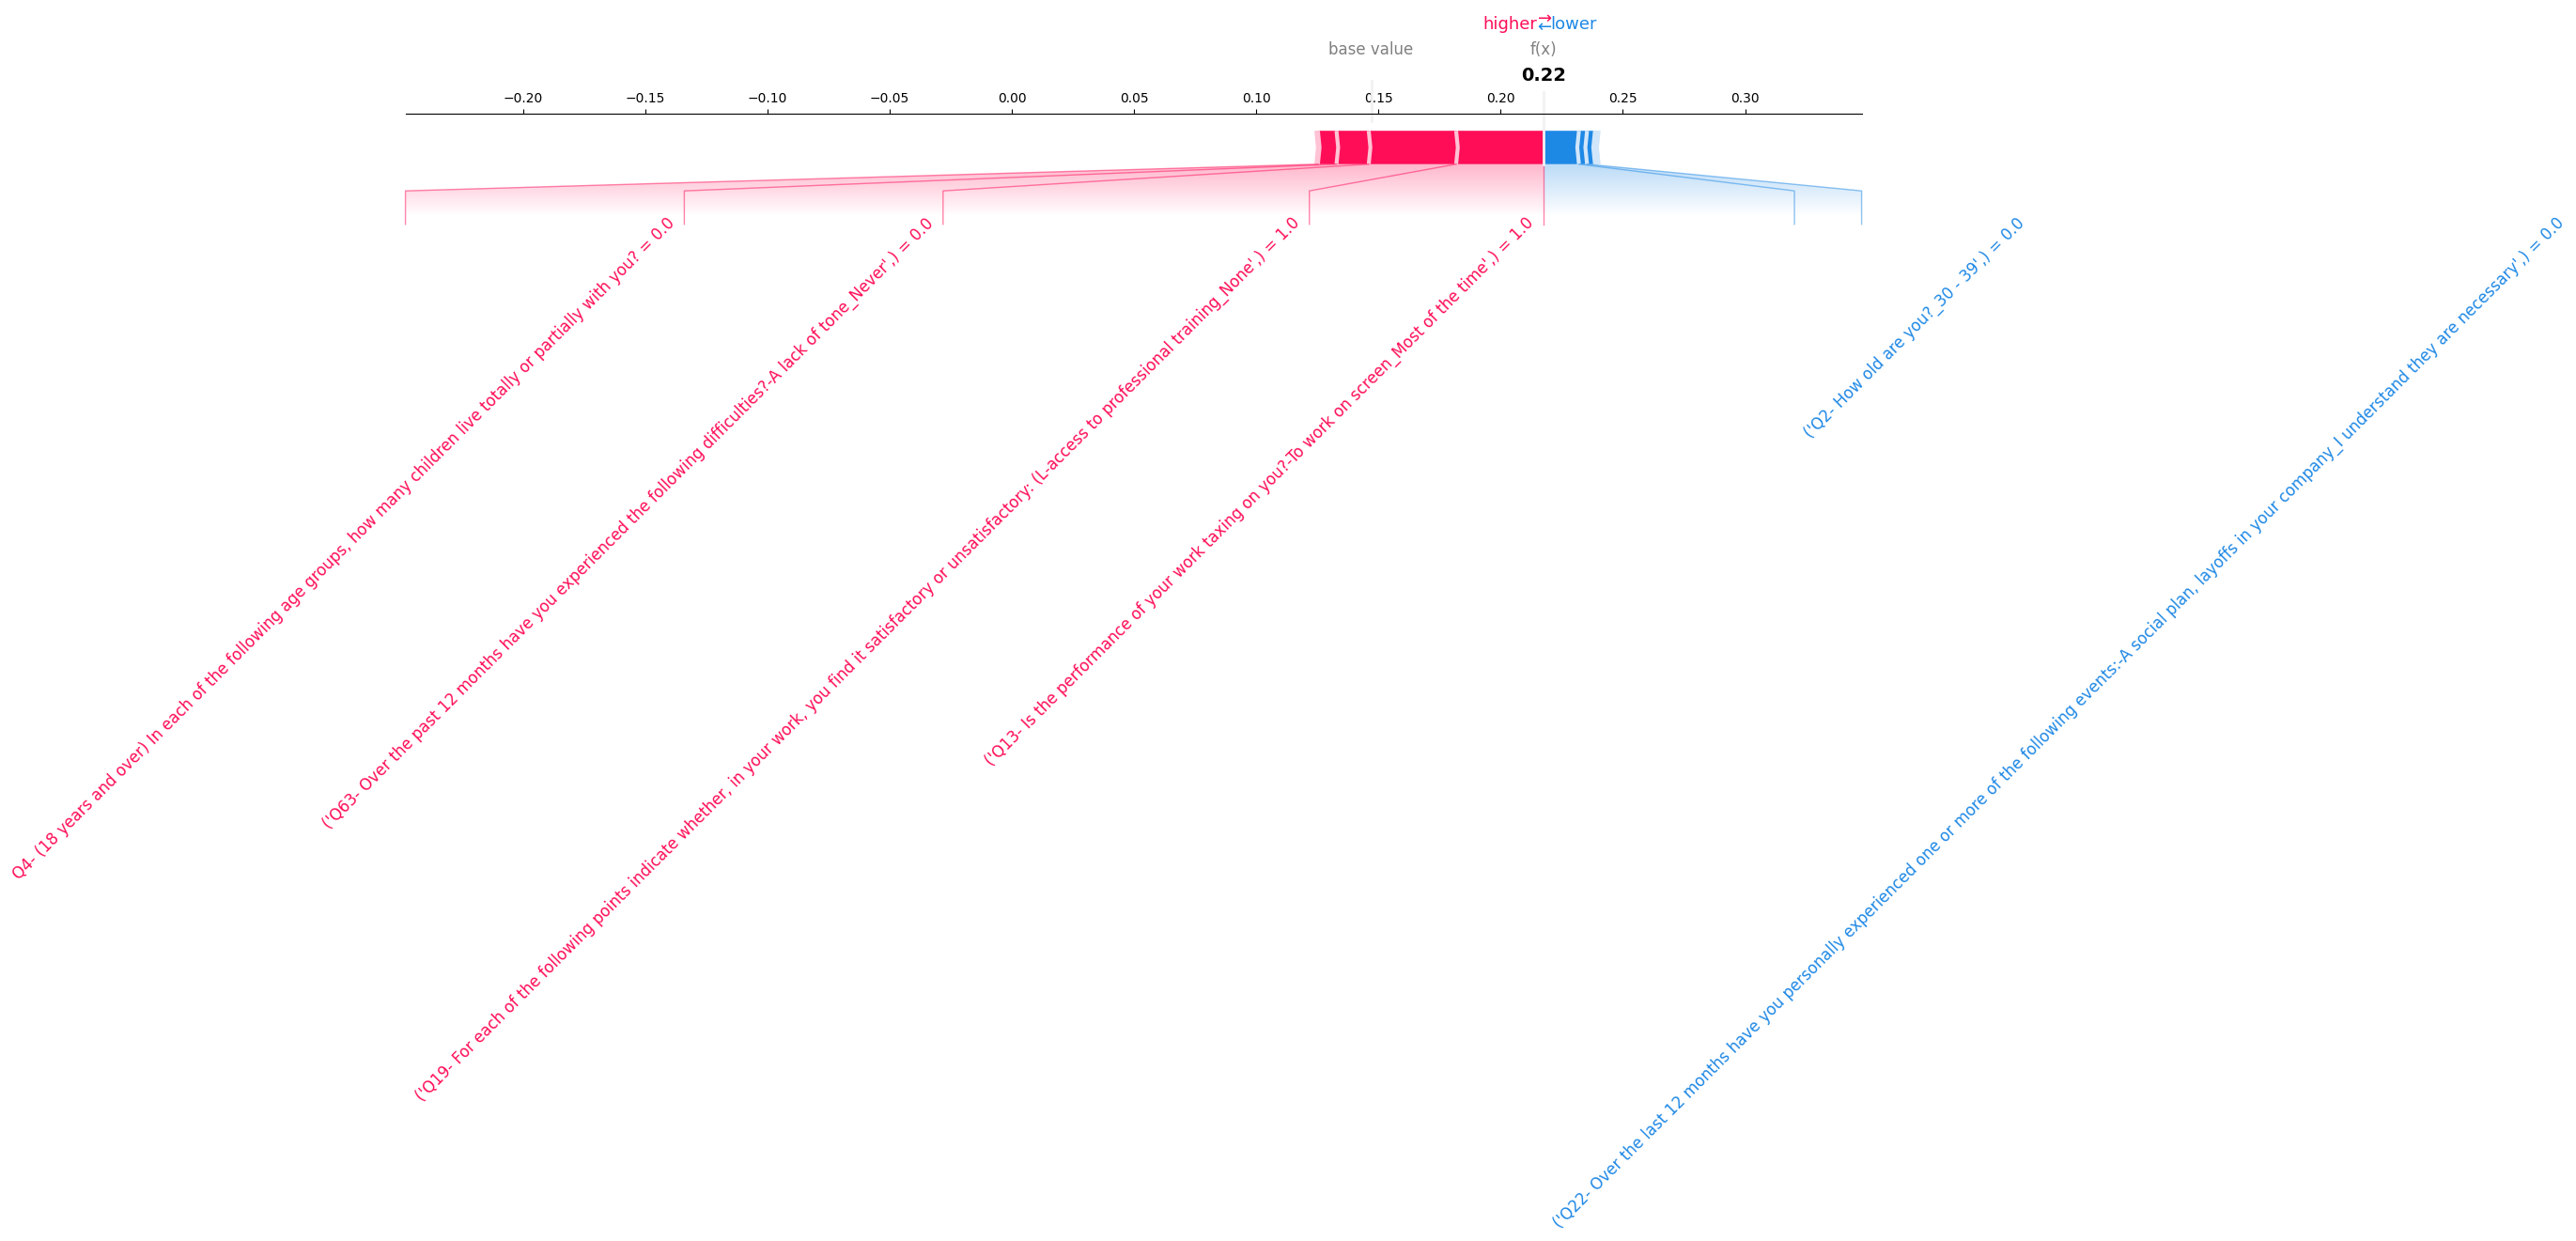

In [31]:
shap.force_plot(explanation.base_values[0], shap_values[0,:], X.iloc[0,:], text_rotation=45, matplotlib=True, show= False) # shows the shap values for the second prediction
plt.savefig('outputs/02_01_shap/shap_force_plot_xg_4.png')
plt.show()

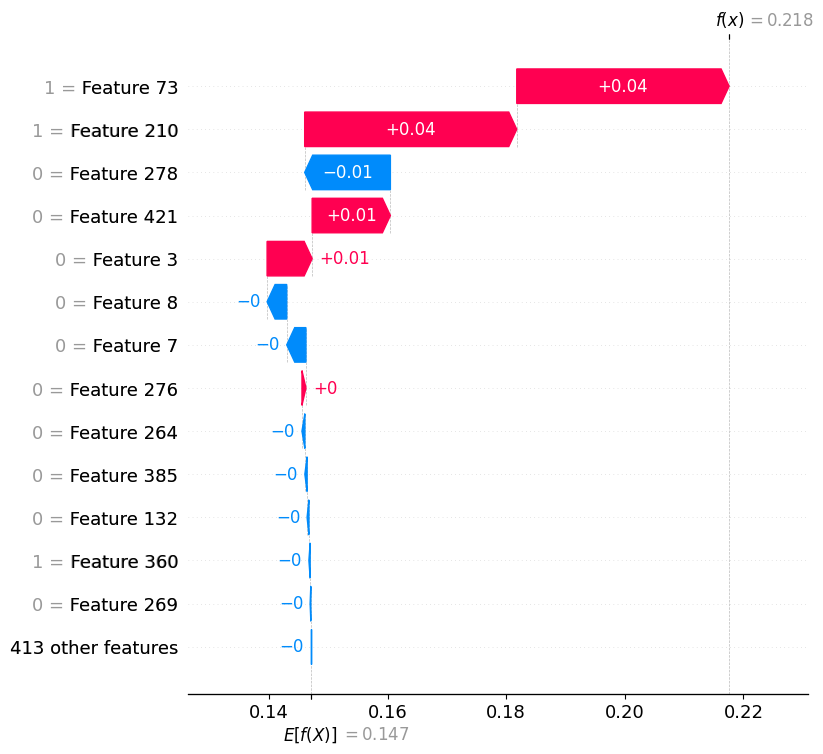

In [32]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(explanation[0,:], max_display=14, show=False)
plt.figsize=(32,18)
plt.savefig('outputs/02_01_shap/shap_waterfall_plot_xg_4.png')
plt.show()

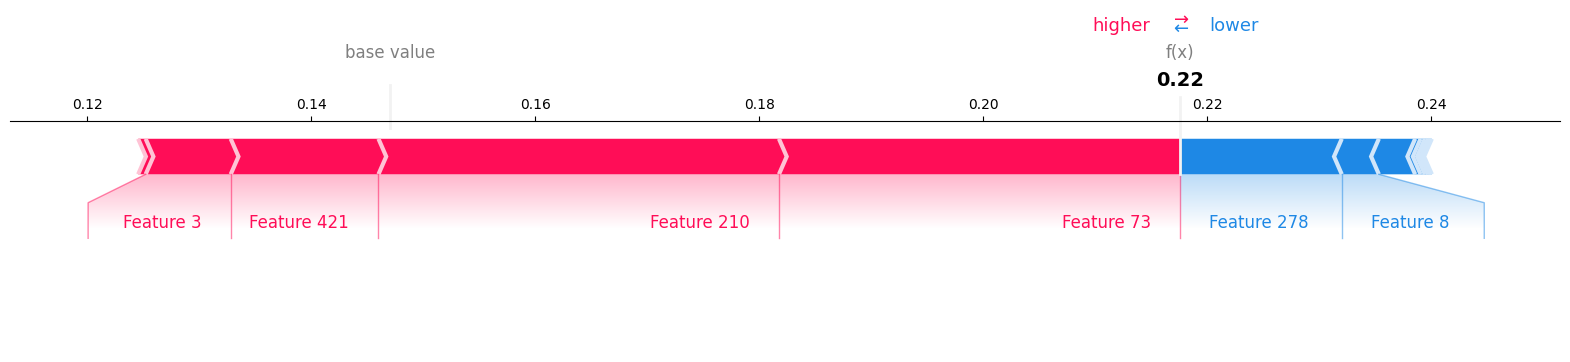

In [33]:
shap.plots.force(explainer.expected_value, shap_values[0, ...], show= False, matplotlib=True) # shap_values[0, ...] is the SHAP values for the first instance in the dataset ... is a numpy slice that means "all of the other axes"
plt.savefig('outputs/02_01_shap/shap_force_plot_xg_4_2.png')
plt.show()

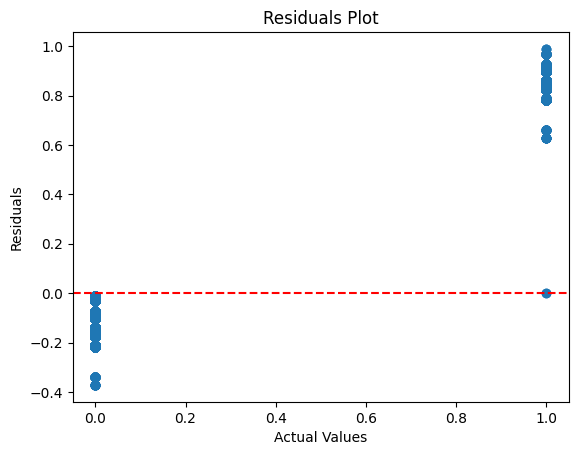

In [34]:
residuals = y - model.predict(Xd)
plt.scatter(y, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# save the plot
plt.savefig('outputs/02_01_shap/residuals_plot.png')
plt.show()

In [35]:
st = time.time()
clustering = shap.utils.hclust(X, y)
et = time.time()
print(time_e(st, et, "Clustering"))

427it [05:07,  1.38it/s]                         

Elapsed time to compute Clustering: 5 minutes and 12 seconds


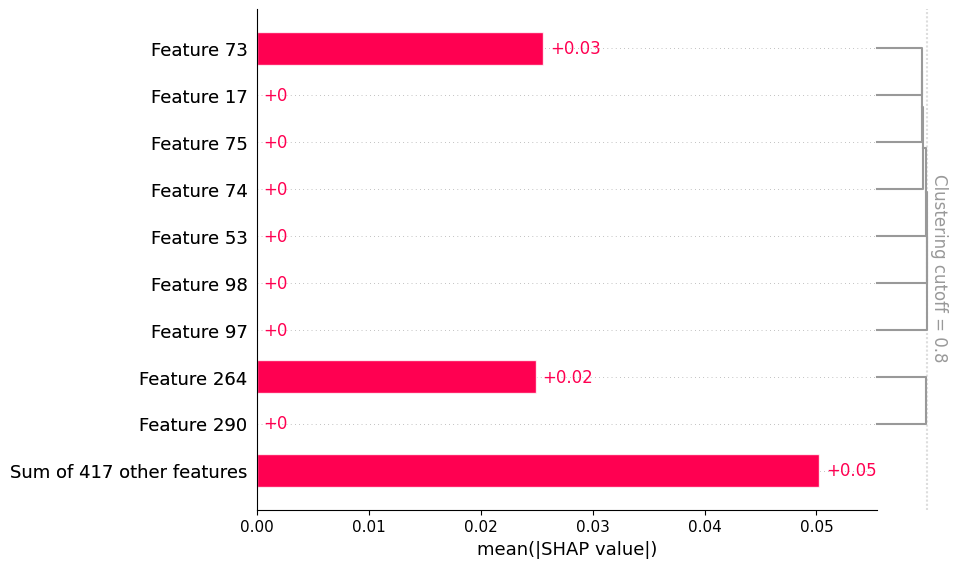

In [36]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=0.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3.png')
plt.show()

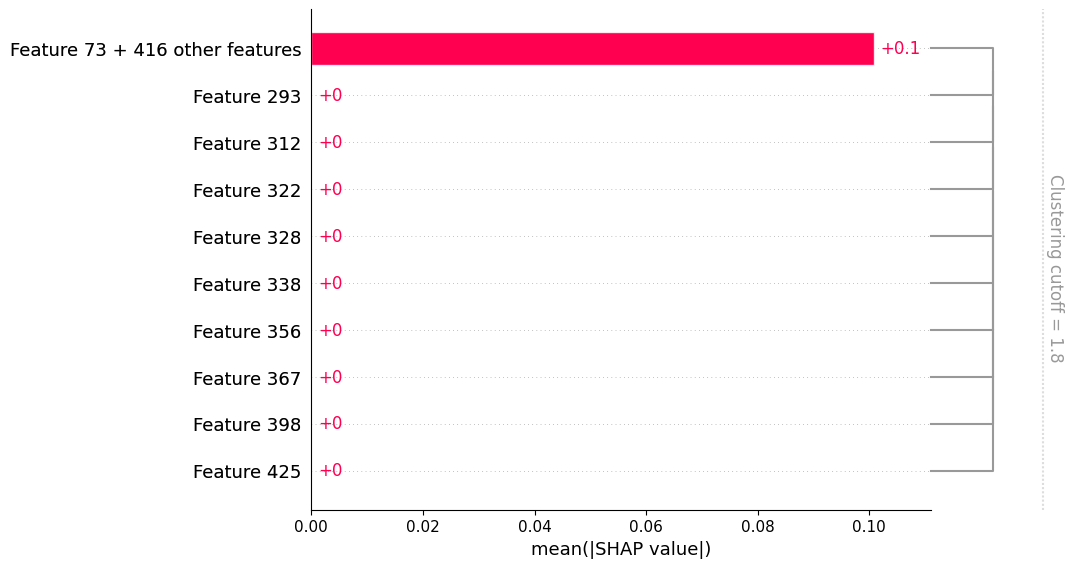

In [37]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=1.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3_1_8.png')
plt.show()